# Structured Illumination Microscopy
## Basic reconstruction of SIM
---
**Notebook 6 — 2026**
<div style="font-size:15px; padding:8px; margin:2px; font-weight:600; background-color:#E80808; color:white;text-align:center;">
    <div style=" ">
        Introduction to Multidimensional Fourier Transform
    </div>
</div>
<div style="border-bottom: 1px gray dotted; padding:8px;margin:2px;text-align:center; font-size:15px; color:#444;">
<i>Daniel Sage — École Polytechnique Fédérale de Lausanne (EPFL)</i>
</div>

**Important notice**: These interactive notebooks complement the lecture and are not self-contained; in-class explanations are required.

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from matplotlib.patches import Circle
from skimage.filters import gaussian

layout = Layout(width='400px') # Layout widgets
style  = {'description_width': '200px'} # Style widgets
plt.rcParams["figure.dpi"]=120
plt.rcParams["image.cmap"] = "gray"

size=256
angles = [0,60,120]    # SIM angles
phases = [0,120,240]   # SIM phases

def fft2c(x): return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(F): return np.fft.ifft2(np.fft.ifftshift(F))
def radial_grid(n):a=(np.arange(n)-n//2)/n; X,Y=np.meshgrid(a,a); return np.sqrt(X*X+Y*Y)
def snr(x,y): return 10*np.log10(np.mean(x*x)/(np.mean((x-y)**2)+1e-12))
def showim(ax,img,title=None): 
    ax.imshow(img); ax.axis("off"); 
    if title is not None: ax.set_title(title); 
def showFM(ax,F,title=None): 
    ax.imshow(np.log(np.abs(F)+1e-12),cmap="inferno"); ax.axis("off"); 
    if title is not None: ax.set_title(title); 
def conv(x, y): return np.real(ifft2c(fft2c(x) * fft2c(np.fft.fftshift(y))))
def shiftF(F, shift): return np.roll(np.roll(F, shift[1], axis=0), shift[0], axis=1)

In [ ]:
# Helpers
def siemens_star(n=128, spokes=12):
    yy,xx=np.mgrid[-1:1:complex(n),-1:1:complex(n)]
    r=np.sqrt(xx*xx+yy*yy); th=np.arctan2(yy,xx)
    img=(np.cos(spokes*th)>0).astype(float)
    img*= (r<0.8); img=gaussian(img,0.5)
    img=(img-img.min())/(img.max()-img.min())
    return img

def create_psf(freqcut):
    r=radial_grid(size)
    H=(r<=freqcut).astype(float)
    psf=np.abs(ifft2c(H))**2
    psf=np.fft.fftshift(psf)/psf.sum()
    return psf

def simulation_acq(im, psf, noise):
    wf = conv(im, psf)
    if noise > 0:
        scale = 1.0 / (0.02*noise + 1e-12)
        wf = np.random.poisson(wf * scale) / scale
        wf = wf + 0.02*noise * np.random.randn(*wf.shape)
    return wf

def create_patterns(period, m=1.0):
    X, Y = np.meshgrid((np.arange(size) - size//2), (np.arange(size) - size//2))
    P = []
    for angle in angles:
        kx = np.cos(np.deg2rad(angle)) / period; ky = np.sin(np.deg2rad(angle)) / period
        for phase in phases: P.append(1.0 + m*np.cos(2*np.pi*(kx*X + ky*Y) + np.deg2rad(phase)))
    return np.stack(P, 0)

def simulation_sim(im, period, fc, noise = 0.0):
    P = create_patterns(period)
    psf = create_psf(fc)
    y = simulation_acq(im*P, psf, noise)
    return y

## 6.1 Generate a synthetic structure — Siemens Star

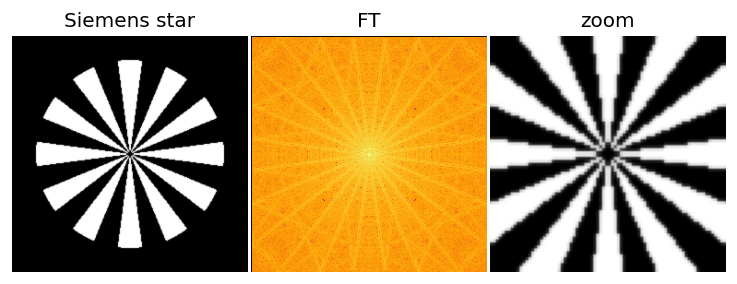

In [3]:
img = siemens_star(size)
fig,ax=plt.subplots(1,3,figsize=(6,3))
showim(ax[0],img,"Siemens star")
showFM(ax[1],fft2c(img),"FT")
showim(ax[2],img[size//2-40:size//2+40,size//2-40:size//2+40],"zoom")
plt.tight_layout(pad=0.2)
plt.show()

## 6.2 PSF as a pupil function

In [4]:
@interact(freqcut=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05,readout_format='.3f',description='Frequency cut',layout=layout,style=style),)
def demo_psf(freqcut):
    psf=create_psf(freqcut)    
    fig,ax=plt.subplots(1,2,figsize=(6,3))
    showFM(ax[0],fft2c(psf),"OTF")
    showim(ax[1],psf,"PSF")
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=0.05, description='Frequency cut', layout=Layout(width='400px'), max=0…

## 6.3 Simulation of widefield acquisition

In [5]:
@interact(
    freqcut=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05,readout_format='.3f',description='Frequency cut',layout=layout,style=style),
    noise=FloatSlider(min=0,max=1,step=0.1,value=0.1,readout_format='.3f',layout=layout,style=style)
)
def demo_acq(freqcut, noise):
    psf = create_psf(freqcut) 
    wf_noiseless = simulation_acq(img, psf, 0)
    wf_noisy = simulation_acq(img, psf, noise)
    fig,ax=plt.subplots(2,3,figsize=(6,4))
    showim(ax[0,0],img,"GT")
    showim(ax[0,1],wf_noiseless,f"WF noiseless {snr(img, wf_noiseless):.2f} dB")
    showim(ax[0,2],wf_noisy ,f"WF noisy {snr(img, wf_noisy):.2f} dB")    
    showFM(ax[1,0],fft2c(img))
    showFM(ax[1,1],fft2c(wf_noiseless))
    showFM(ax[1,2],fft2c(wf_noisy))
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=0.05, description='Frequency cut', layout=Layout(width='400px'), max=0…

## 6.4 Simulation of the illumination patterns

In [6]:
@interact(period=FloatSlider(min=2, max=32, step=1, value=10, layout=layout,style=style))
def demo_patterns(period):  
    P=create_patterns(period)
    fig,ax=plt.subplots(3,6,figsize=(10,5))
    for i,angle in enumerate(angles):
        for j,phase in enumerate(phases): 
            showim(ax[j,2*i],P[i+3*j],f"θ={angle}° φ={phase}°")
            showFM(ax[j,2*i+1], fft2c(P[i+3*j]),f"θ={angle}° φ={phase}°")
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=10.0, description='period', layout=Layout(width='400px'), max=32.0, mi…

## 6.5 Simulation of SIM acquisition

In [7]:
@interact(period=FloatSlider(min=1, max=32, step=0.25, value=6.25,description='Period', layout=layout,style=style),
          freqcut=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05,readout_format='.3f',description='Frequency cut',layout=layout,style=style),
          noise=FloatSlider(min=0,max=1,step=0.1,value=0.0,readout_format='.3f',description='Noise',layout=layout,style=style),
         )
def demo_simualtion_patterns(freqcut, period, noise): 
    y = simulation_sim(img, period, freqcut, noise)
    fig,ax=plt.subplots(3,3,figsize=(5,5))
    for i,angle in enumerate(angles):
        for j,phase in enumerate(phases): showim(ax[j,i],y[i+3*j],f"θ={angle}° φ={phase}°")
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=0.05, description='Frequency cut', layout=Layout(width='400px'), max=0…

## 6.6 Partial SIM reconstruction

In [8]:
@interact(period=FloatSlider(min=1, max=32, step=0.25, value=6.25,description='Period', layout=layout,style=style),
          freqcut=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05,readout_format='.3f',description='Frequency cut',layout=layout,style=style),
          angle=IntSlider(min=0,max=2,step=1,value=1,description='Angle',layout=layout,style=style),
         )
def partial_sim_reconstruction(freqcut, period, angle): 
    y = simulation_sim(img, period, freqcut, 0)
    A = np.array([[1, np.exp(1j*np.deg2rad(p))/2, np.exp(-1j*np.deg2rad(p))/2] for p in phases], dtype=complex) 
    Ai = np.linalg.inv(A)
    u = np.stack([np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles))], axis=1) / period
    a = angle
    Ys =  fft2c(y[3*a:3*a+3]) 
    C0 = Ai[0,0]*Ys[0] + Ai[0,1]*Ys[1] + Ai[0,2]*Ys[2]
    Cp = shiftF(Ai[1,0]*Ys[0] + Ai[1,1]*Ys[1] + Ai[1,2]*Ys[2], -u[a]*size)
    Cn = shiftF(Ai[2,0]*Ys[0] + Ai[2,1]*Ys[1] + Ai[2,2]*Ys[2], u[a]*size)
    fig, ax = plt.subplots(2, 4, figsize=(10, 5))
    showim(ax[0,0], np.real(ifft2c(C0)), "C0")
    showim(ax[0,1], np.real(ifft2c(Cp)), "C+")
    showim(ax[0,2], np.real(ifft2c(Cn)), "C−")
    showim(ax[0,3], np.real(ifft2c(C0 + Cp + Cn)), f"θ={round(angles[a])}°")
    showFM(ax[1,0], C0)
    showFM(ax[1,1], Cp)
    showFM(ax[1,2], Cn)
    showFM(ax[1,3], C0 + Cp + Cn)
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=0.05, description='Frequency cut', layout=Layout(width='400px'), max=0…

## 6.7 SIM reconstruction

In [9]:
def sim_reconstruction(y, u, psf, power_wiener_reg=-3):
    regul = np.power(10.0,power_wiener_reg)
    A = np.array([[1, np.exp(1j*np.deg2rad(p))/2, np.exp(-1j*np.deg2rad(p))/2] for p in phases], dtype=complex) 
    Ai = np.linalg.inv(A)
    OTFc = fft2c(np.fft.ifftshift(psf))
    denominator =  3*np.abs(OTFc)**2  # Put altready the three WF contributions
    C0_all, Cp_all, Cn_all = [], [], []
    for a in range(3):
        Ys =  fft2c(y[3*a:3*a+3]) 
        C0 = Ai[0,0]*Ys[0] + Ai[0,1]*Ys[1] + Ai[0,2]*Ys[2]
        Cp = Ai[1,0]*Ys[0] + Ai[1,1]*Ys[1] + Ai[1,2]*Ys[2]
        Cn = Ai[2,0]*Ys[0] + Ai[2,1]*Ys[1] + Ai[2,2]*Ys[2]
        OTFp = shiftF(OTFc, -u[a]*size)
        OTFm = shiftF(OTFc,  u[a]*size)
        denominator += np.abs(OTFp)**2 + np.abs(OTFm)**2
        C0_all += [np.conj(OTFc) * C0] 
        Cp_all += [np.conj(OTFp) * shiftF(Cp, -u[a]*size)] 
        Cn_all += [np.conj(OTFm) * shiftF(Cn, u[a]*size)]
    Fsim = (sum(C0_all) + sum(Cp_all) + sum(Cn_all)) / (denominator + regul)
    sim = np.real(ifft2c(Fsim))
    #sim = np.maximum(sim, 0)
    return sim
    
def sim_ideal_mask(img, u):
    fy = np.fft.fftfreq(size); 
    fx = np.fft.fftfreq(size); 
    FX, FY = np.meshgrid(fx, fy)
    mask_ideal = (FX**2 + FY**2) <= (fc*2)**2
    sgn = np.array([+1, -1])[:, None, None]   # shape (2,1,1)
    for a in range(3):
        mask_ideal |= np.any(((FX - sgn*u[a,0])**2 + (FY - sgn*u[a,1])**2) <= (fc*2)**2, axis=0)
    Fim = np.fft.fft2(img)
    ideal = np.real(np.fft.ifft2(Fim * np.float64(mask_ideal)))
    return ideal

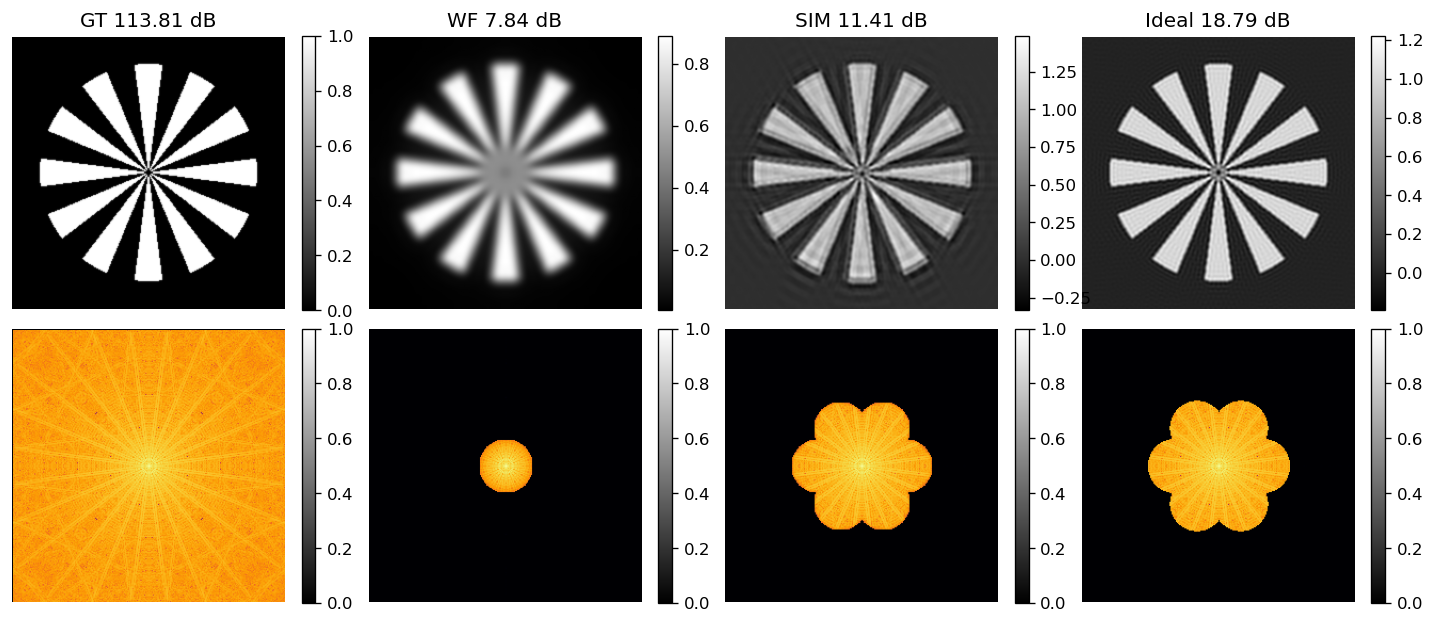

In [10]:
fc = 0.05 ; noise = 0. ; period = 6.24
wf = simulation_acq(img, create_psf(fc), noise)
y = simulation_sim(img, period, fc, noise)
psf = create_psf(fc)
u = np.stack([np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles))], axis=1) / period

# SIM reconstruction
sim = sim_reconstruction(y,u,psf)

# SIM ideal masking
ideal =  sim_ideal_mask(img, u)

def decorate(ax, title, snrv=None): ax.set_title(title if snrv is None else f"{title} {snrv:.2f} dB"); ax.axis("off")
fig, ax = plt.subplots(2,4,figsize=(12,5))
im0 = ax[0,0].imshow(img); decorate(ax[0,0], "GT",  snr(img,img)); fig.colorbar(im0, ax=ax[0,0])
im1 = ax[0,1].imshow(wf);  decorate(ax[0,1], "WF",  snr(img,wf )); fig.colorbar(im1, ax=ax[0,1])
im2 = ax[0,2].imshow(sim); decorate(ax[0,2], "SIM", snr(img,sim)); fig.colorbar(im2, ax=ax[0,2])
im3 = ax[0,3].imshow(ideal); decorate(ax[0,3], "Ideal", snr(img,ideal));fig.colorbar(im3, ax=ax[0,3])
fm0 = showFM(ax[1,0],fft2c(img)); fig.colorbar(fm0, ax=ax[1,0])
fm1 = showFM(ax[1,1],fft2c(wf));fig.colorbar(fm1, ax=ax[1,1])
fm2 = showFM(ax[1,2],fft2c(sim));fig.colorbar(fm2, ax=ax[1,2])
fm3 = showFM(ax[1,3],fft2c(ideal));fig.colorbar(fm3, ax=ax[1,3])
plt.tight_layout(pad=0.2); plt.show()

## 6.8 Demonstrator SIM - Inverse Crime

In [13]:
def decorate(ax, title, snrv=None): ax.set_title(title if snrv is None else f"{title} {snrv:.2f} dB"); ax.axis("off")

@interact(period=FloatSlider(min=1, max=32, step=0.25, value=6,description='Period', layout=layout,style=style),
          freqcut=FloatSlider(min=0.001, max=0.2, step=0.001, value=0.05,readout_format='.3f',description='Frequency cut',layout=layout,style=style),
          noise=FloatSlider(min=0,max=1,step=0.1,value=0.0,readout_format='.3f',description='Noise',layout=layout,style=style),
          preg=FloatSlider(min=-10,max=10,step=0.5,value=-3.0,readout_format='.3f',description='Regularization', layout=layout,style=style)
         )
def demo(freqcut,period, noise, preg):
    wf = simulation_acq(img, create_psf(freqcut), noise)
    psf = create_psf(freqcut)
    y = simulation_sim(img, period, freqcut, noise)
    u = np.stack([np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles))], axis=1) / period
    sim = sim_reconstruction(y,u,psf,preg)
    fig, ax = plt.subplots(1,4,figsize=(10,5))
    im1 = ax[0].imshow(wf);  decorate(ax[0], "WF",  snr(img,wf ));
    im2 = ax[2].imshow(sim); decorate(ax[2], "SIM", snr(img,sim));
    fm1 = showFM(ax[1],fft2c(wf))
    fm2 = showFM(ax[3],fft2c(sim))
    plt.tight_layout(pad=0.2); plt.show()

interactive(children=(FloatSlider(value=0.05, description='Frequency cut', layout=Layout(width='400px'), max=0…

## 6.9 Demonstrator SIM - Uncertain Calibration

In [ ]:
def decorate(ax, title, snrv=None): ax.set_title(title if snrv is None else f"{title} {snrv:.2f} dB"); ax.axis("off")

@interact(freqcut_variation=FloatSlider(min=-0.01, max=0.01, step=0.001, value=0.001,readout_format='.3f',description='PSF uncalibration', layout=layout,style=style),
          noise=FloatSlider(min=0,max=1,step=0.1,value=0.0,readout_format='.3f',description='Noise',layout=layout,style=style),
          pattern_variation=FloatSlider(min=0, max=1, step=0.1, value=0.1,readout_format='.3f',description='Pattern uncalibration',layout=layout,style=style),
          preg=FloatSlider(min=-10,max=10,step=0.5,value=-3.0,readout_format='.3f',description='Regularization', layout=layout,style=style))
def demo(freqcut_variation,noise,pattern_variation,preg):
    freqcut = 0.05
    period = 6
    wf = simulation_acq(img, create_psf(freqcut), noise)
    psf = create_psf(freqcut+freqcut_variation)
    y = simulation_sim(img, period, freqcut, noise)
    sim = sim_reconstruction(y,u, psf, preg)
    fig, ax = plt.subplots(1,4,figsize=(10,5))
    im1 = ax[0].imshow(wf);  decorate(ax[0], "WF",  snr(img,wf ));
    im2 = ax[2].imshow(sim); decorate(ax[2], "SIM", snr(img,sim));
    fm1 = showFM(ax[1],fft2c(wf))
    fm2 = showFM(ax[3],fft2c(sim))
    plt.tight_layout(pad=0.2); plt.show()